#  Инициализация весов нейронных сетей. Способы регуляризации нейронных сетей. Продвинутые алгоритмы градиентного спуска.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.init.html
* https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
* https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
* https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
* https://pytorch.org/docs/stable/optim.html
* https://seaborn.pydata.org/examples/errorband_lineplots.html

## Задачи для совместного разбора

1\. Инициализируйте веса полносвязного слоя единицами, а смещения - нулями.

2\. Изучите, как работает слой `nn.Dropout` в режиме обучения модели и в режиме использования модели.

3\. Изучите, как работает слой `nn.BatchNorm1d` в режиме обучения модели и в режиме использования модели.

## Задачи для самостоятельного решения

In [40]:
import torch as th
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.regression import R2Score, MeanAbsolutePercentageError

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.datasets import load_diabetes

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

<p class="task" id="1"></p>

1\. Расширьте класс `torch.nn.Linear`, описав класс `InitializedLinear` и добавив возможность инициализировать веса слоя при помощи функций из пакета `torch.nn.init` (инициализацию bias оставьте по умолчанию). Обратите внимание, что данные функции имеют дополнительные параметры. Данные параметры должны передаваться в момент создания объекта класса `InitializedLinear`.

Пример создания слоя:
```
InitializedLinear(n_features, n_hidden, init_f=nn.init.uniform_, init_args={"a": 0.0, "b": 1.0})
```

- [ ] Проверено на семинаре

In [41]:
import torch.nn as nn

class InitializedLinear(nn.Linear):
    def __init__(self, n_features, n_hidden, bias = True, init_f=None, init_args=None):
        super().__init__(n_features,n_hidden, bias=bias)
        if init_f:
            init_args = init_args or {}
            with th.no_grad():
                init_f(self.weight, **init_args)

X = th.randn(3,4)

model = nn.Sequential(
    InitializedLinear(X.shape[1], 2,init_f=nn.init.uniform_, init_args={"a": 0.0, "b": 1.0})
)

model(X)

tensor([[-0.8628, -0.5021],
        [ 1.0426,  0.2514],
        [ 0.6491, -0.5212]], grad_fn=<AddmmBackward0>)

<p class="task" id="2"></p>

2\. Решите задачу регрессии несколько раз, изменяя способ инициализации весов. Рассмотрите следующие варианты:
* `nn.init.uniform_`
* `nn.init.normal_`
* `nn.init.constant_`
* `nn.xavier_uniform_` 
* `nn.kaiming_uniform_`
* `nn.xavier_normal_`
* `nn.kaiming_normal_`

Визуализируйте график изменения значений MSE с ходом эпох. Дайте кривым, соответствующие разным способам инициализации, различные цвета и добавьте подписи. Обратите внимание, что от запуска к запуску результаты могут отличаться. Чтобы решить эту проблему, обучайте каждую модель несколько раз и визуализируйте доверительный интервал (можно воспользоваться `seaborn.lineplot`).

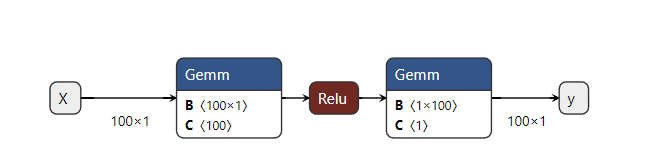

- [ ] Проверено на семинаре

Training model with uniform_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with normal_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with constant_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with xavier_uniform_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with kaiming_uniform_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with xavier_normal_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

Training model with kaiming_normal_ init func:   0%|          | 0/20 [00:00<?, ?it/s]

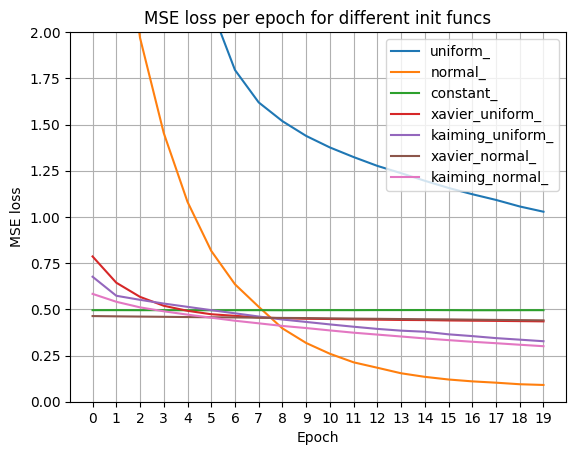

In [42]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

EPOCHS = 20

inits = {
    nn.init.uniform_:           None,
    nn.init.normal_:            None,
    nn.init.constant_:          {"val":0},
    nn.init.xavier_uniform_:    None,
    nn.init.kaiming_uniform_:   None,
    nn.init.xavier_normal_:     None,
    nn.init.kaiming_normal_:    None
}



dset = TensorDataset(X,y)
loader = DataLoader(dset, batch_size=16, shuffle=True)
for key in inits.keys():
    model = nn.Sequential(
        InitializedLinear(X.shape[1],100, init_f=key, init_args=inits[key]),
        nn.ReLU(),
        InitializedLinear(100, y.shape[1], init_f=key, init_args=inits[key])
    )
    criterion = nn.MSELoss()
    optimizer = th.optim.SGD(model.parameters())
    losses = []

    for epoch in tqdm(range(EPOCHS), f'Training model with {key.__name__} init func'):
        for X_batch,y_batch in loader:
            y_pred = model(X_batch).flatten()
            loss = criterion(y_pred, y_batch.flatten())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        

        with th.no_grad():
            preds = model(X)
            losses.append(mean_squared_error(y.numpy(), preds.numpy()))
        

    
    sns.lineplot(losses, label=key.__name__)

plt.title('MSE loss per epoch for different init funcs')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.ylim(0,2)
plt.xticks(range(EPOCHS))
plt.grid()

<p class="task" id="3"></p>

3\. Исследуйте, как добавление дропаута влияет на процесс обучения модели. Решите задачу регрессии несколько раз, изменяя значения вероятности дропаута $p$ от 0 до 0.8. В качестве модели рассмотрите нейронную сеть с одним скрытым слоем.

Визуализируйте график изменения значений $R^2$ в зависимости от вероятности дропаута $p$ на обучающей и тестовой выборке. Визуализируйте на отдельном графике зависимости разности между $R^2$ на обучающей выборки и $R^2$ на тестовой выборке.

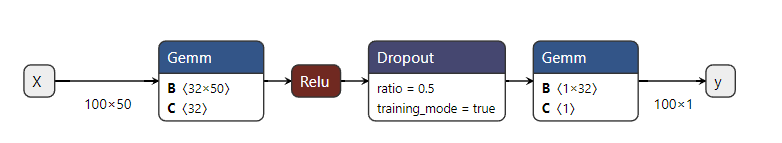

- [ ] Проверено на семинаре

Исследование Dropout:   0%|          | 0/30 [00:00<?, ?it/s]

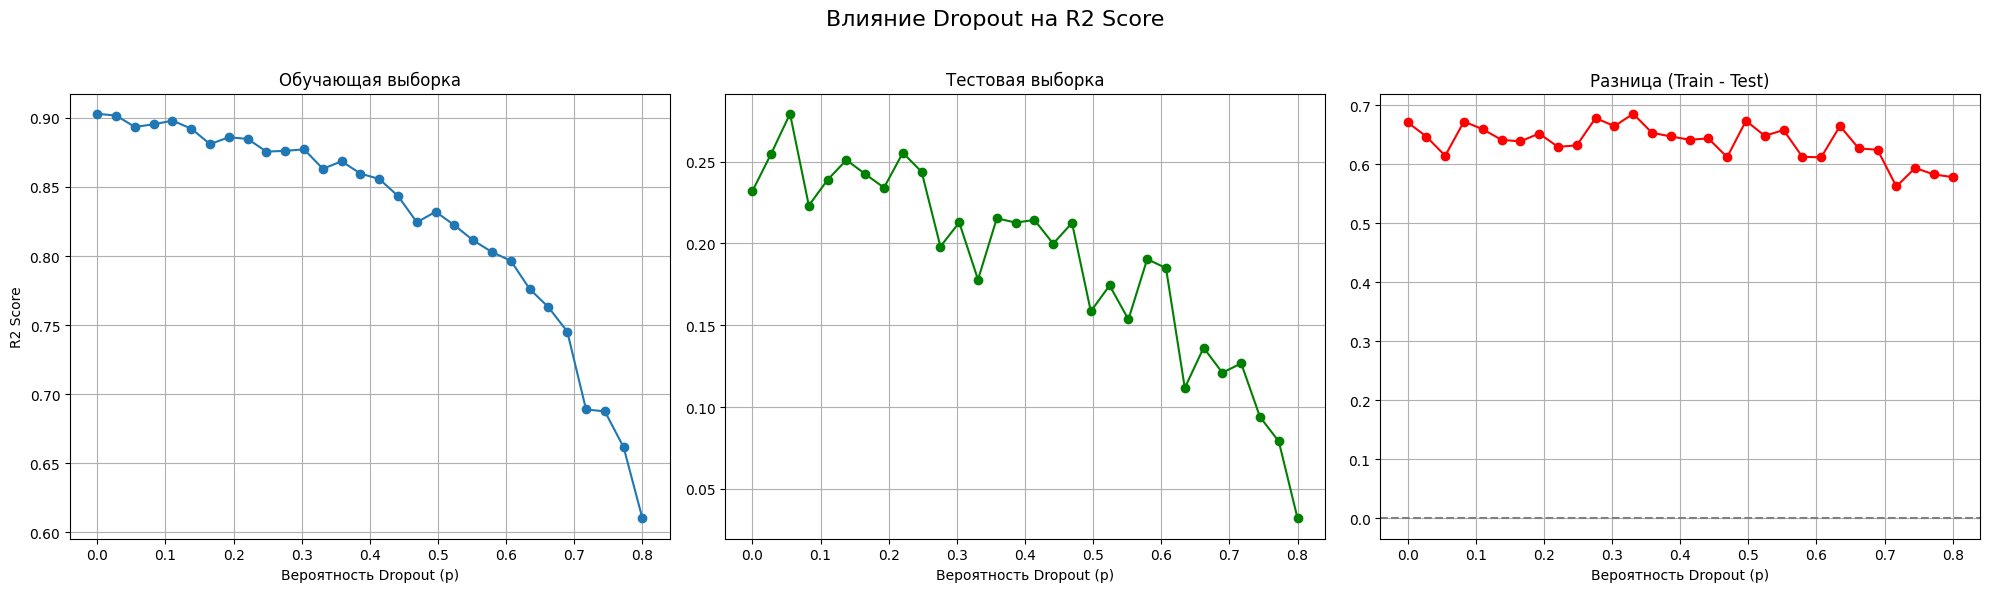

In [43]:
th.manual_seed(42)
X, y, coef = make_regression(
    n_samples=100, 
    n_features=50, 
    n_informative=20, 
    noise=2,
    coef=True,  
    random_state=42,
    
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

EPOCHS = 200
NESKOLKO = 30
dropout_rates = np.linspace(0, 0.8, NESKOLKO)
metric = R2Score()

r2_train_scores = []
r2_test_scores = []

for p in tqdm(dropout_rates, desc="Исследование Dropout"):
    model = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(64, 1)
    )
    criterion = nn.MSELoss()
    optimizer = th.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(EPOCHS):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with th.no_grad():
        train_preds = model(X_train)
        r2_train_scores.append(metric(train_preds, y_train).item())
        
        test_preds = model(X_test)
        r2_test_scores.append(metric(test_preds, y_test).item())

r2_train_scores = np.array(r2_train_scores)
r2_test_scores = np.array(r2_test_scores)
r2_diff = r2_train_scores - r2_test_scores

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Влияние Dropout на R2 Score', fontsize=16)

axes[0].plot(dropout_rates, r2_train_scores, marker='o', label='Train R2')
axes[0].set_title('Обучающая выборка')
axes[0].set_xlabel('Вероятность Dropout (p)')
axes[0].set_ylabel('R2 Score')
axes[0].grid(True)

axes[1].plot(dropout_rates, r2_test_scores, marker='o', color='green', label='Test R2')
axes[1].set_title('Тестовая выборка')
axes[1].set_xlabel('Вероятность Dropout (p)')
axes[1].grid(True)

axes[2].plot(dropout_rates, r2_diff, marker='o', color='red', label='Train R2 - Test R2')
axes[2].set_title('Разница (Train - Test)')
axes[2].set_xlabel('Вероятность Dropout (p)')
axes[2].axhline(0, color='grey', linestyle='--')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<p class="task" id="4"></p>

4\. Решите задачу регрессии с и без использования пакетной нормализации. Покажите, как меняется результат обучения моделей при различных значениях скорости обучения (0.001, 0.01, 0.1) за одно и то же количество эпох. 

Визуализируйте график изменения значений $R^2$ в зависимости от эпохи при различных значениях скорости обучения с- и без использования пакетной нормализации.

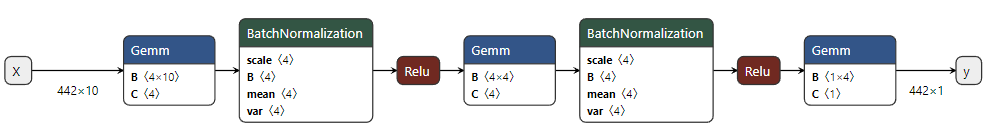

- [ ] Проверено на семинаре

lr=0.001, batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

lr=0.001, no batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

lr=0.01, batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

lr=0.01, no batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

lr=0.1, batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

lr=0.1, no batch model:   0%|          | 0/1000 [00:00<?, ?it/s]

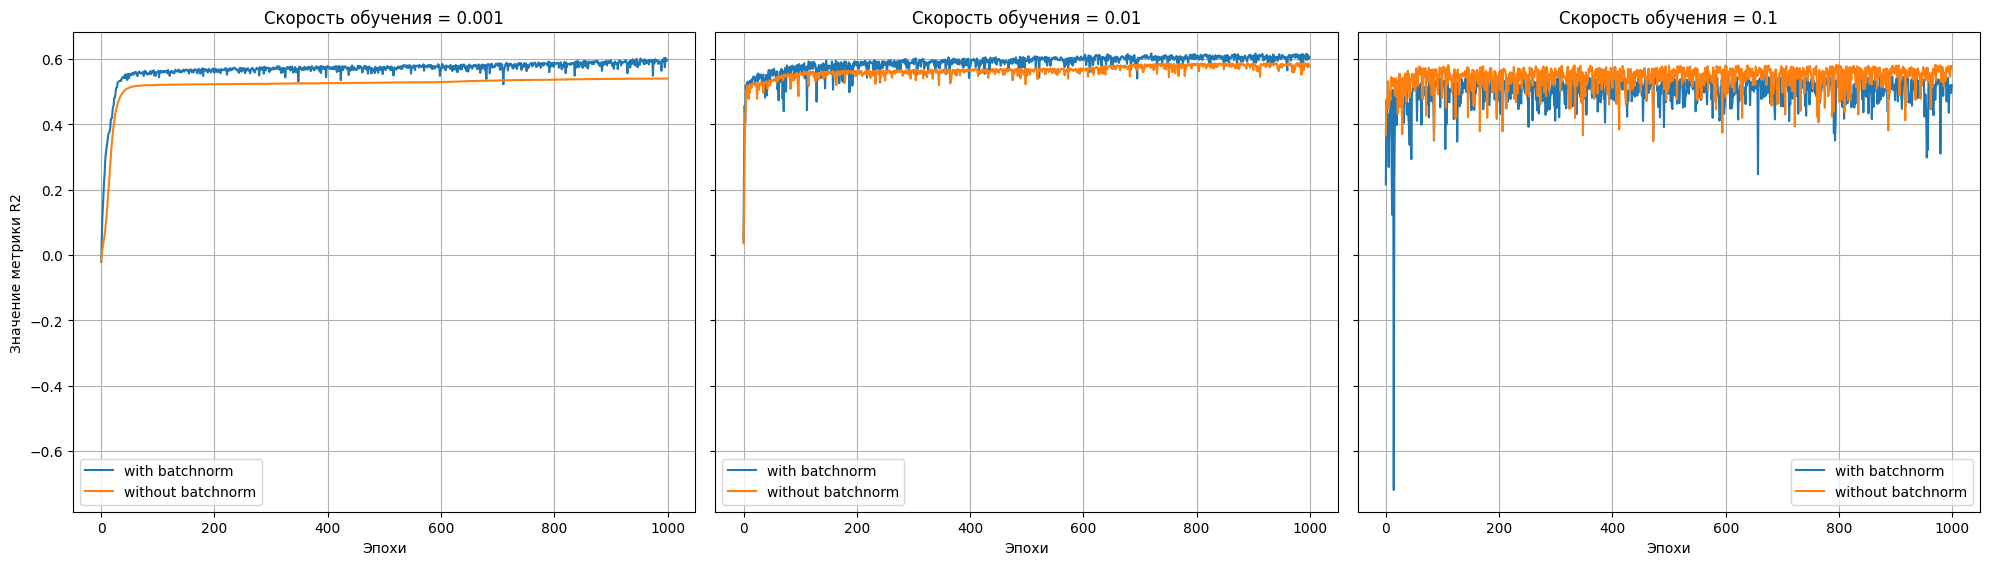

In [44]:
X, y = load_diabetes(return_X_y=True)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)
y = (y - y.mean())/y.std()

EPOCHS = 1000
dset = TensorDataset(X,y)
loader = DataLoader(dset, batch_size=16, shuffle=True)
metric = R2Score()
r2_scores = defaultdict(list)
lrs = [0.001, 0.01, 0.1]

for lr in lrs:
    model_batch = nn.Sequential(
        nn.Linear(10,4),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.Linear(4,4),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.Linear(4,1)
    )
    model_no_batch = nn.Sequential(
        nn.Linear(10,4),
        nn.ReLU(),
        nn.Linear(4,4),
        nn.ReLU(),
        nn.Linear(4,1)
    )

    models = {
        'batch':model_batch,
        'no batch':model_no_batch
        }

    for name, model in models.items():
        scores = []
        criterion = nn.MSELoss()
        optimizer = th.optim.Adam(model.parameters(), lr=lr)
        for epoch in tqdm(range(EPOCHS),f'{lr=}, {name} model'):
            model.train()
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
            model.eval()
            with th.no_grad():
                preds = model(X)
                scores.append(metric(preds, y).item())
                
        r2_scores[lr].append(np.array(scores))
        

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i in range(3):
    axes[i].plot(range(EPOCHS),r2_scores[lrs[i]][0], label='with batchnorm')
    axes[i].plot(range(EPOCHS),r2_scores[lrs[i]][1], label='without batchnorm')
    axes[i].set_title(f'Скорость обучения = {lrs[i]}')
    axes[i].set_xlabel('Эпохи')
    if i == 0:
        axes[i].set_ylabel('Значение метрики R2')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<p class="task" id="5"></p>

5\. Решите задачу регрессии c использованием различных алгоритмов градиентного спуска. Покажите, как меняется результат обучения моделей при использовании различных алгоритмов (Adam, Adagrad, RMSProp, SGD) за одно и то же количество эпох с одной и той же скоростью обучения. Используйте модель с архитектурой, аналогичной модели из предыдущей задачи.

Визуализируйте график изменения значений MAPE в зависимости от эпохи при использовании различных алгоритмов градиентного спуска.

- [ ] Проверено на семинаре

In [45]:
def load_boston():
    data_url = r"http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Rog G16\AppData\Local\Temp\ipykernel_33320\2227522201.py:3: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


Adam optimizer:   0%|          | 0/1000 [00:00<?, ?it/s]

Adagrad optimizer:   0%|          | 0/1000 [00:00<?, ?it/s]

RMSprop optimizer:   0%|          | 0/1000 [00:00<?, ?it/s]

SGD optimizer:   0%|          | 0/1000 [00:00<?, ?it/s]

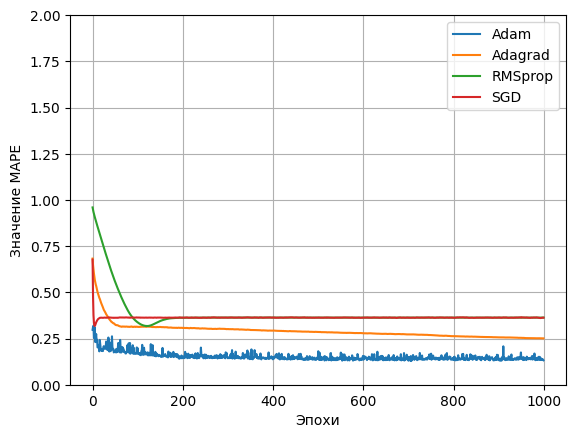

In [46]:
X, y = load_boston()
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)
dset = TensorDataset(X,y)
loader = DataLoader(dset, batch_size=16, shuffle=True)

EPOCHS = 1000
lr = 0.005
optims = [
    th.optim.Adam,
    th.optim.Adagrad,
    th.optim.RMSprop,
    th.optim.SGD
]
metric = MeanAbsolutePercentageError()
mape_scores = defaultdict(list)
for optim in optims:
    model = nn.Sequential(
        nn.Linear(X.shape[1],4),
        nn.ReLU(),
        nn.Linear(4,4),
        nn.ReLU(),
        nn.Linear(4,1)
        )
    optimizer = optim(model.parameters(),lr=lr)
    scores = []
    for epoch in tqdm(range(EPOCHS),f'{optim.__name__} optimizer'):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        with th.no_grad():
            preds = model(X)
            scores.append(metric(preds, y).item())
    mape_scores[optim.__name__] = scores
# plt.figure(figsize=(7,6), dpi=150)
for key,value in mape_scores.items():
    plt.plot(value, label=key)

plt.xlabel("Эпохи")
plt.ylabel("Значение MAPE")
plt.grid()
# plt.xticks(range(EPOCHS))
plt.legend()
plt.ylim(0,2)
plt.show()